In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df = pd.read_excel('./Data/File1.xlsx')

In [3]:
# df.info()

## Feature Engineering

---

In [4]:
# Date the bundle was purchased
purchased_dt = pd.to_datetime('10/24/2008')

# Calculate the days until Out of Statute
df['OOS Days Left'] = df['OOS Date'] - purchased_dt
df['OOS Days Left int'] = 0

for i, _ in df.iterrows():
    days = df.iloc[i]['OOS Days Left'].days
    df.iloc[i,29] = days

In [5]:
# Dummy up the Cycle as this is an important feature
df = pd.get_dummies(df, columns = ['Cycle'])
df.columns

Index(['Account Number', 'PortID', 'Remaining Balance', 'interests Fees',
       'Date Opened', 'Charge Off Date', 'Last Pay Date', 'Last Pay Amount',
       'Last Activity Date', 'Interest Rate %', 'Issuer', 'Merchant',
       'FCFRA Date', 'OOS Date', 'Account Type', 'Last Name', 'First Name',
       'Middle Name', 'Address', 'City', 'State', 'Zip', 'County', 'SSN',
       'Home Phone', 'Employer Phone', 'Paid', 'OOS Days Left',
       'OOS Days Left int', 'Cycle_QUATERNARY', 'Cycle_SECONDARY',
       'Cycle_TERTIARY'],
      dtype='object')

In [6]:
# Write out the new .csv file
df.to_csv("./Data/cleaned.csv", index=False)

In [7]:
num_cols = df.columns[[np.issubdtype(dt, np.number) for dt in df.dtypes]]

drop_cols = [key for key in dict(df.dtypes) 
                if dict(df.dtypes)[key] in ['datetime64[ns]', 'object']]

# Add others to drop list
drop_cols.extend(('Paid','Account Number','SSN','Home Phone',
                  'Employer Phone','OOS Days Left'))

In [8]:
num_cols

Index(['Account Number', 'Remaining Balance', 'interests Fees',
       'Last Pay Amount', 'Interest Rate %', 'SSN', 'Home Phone',
       'Employer Phone', 'Paid', 'OOS Days Left', 'OOS Days Left int',
       'Cycle_QUATERNARY', 'Cycle_SECONDARY', 'Cycle_TERTIARY'],
      dtype='object')

In [9]:
drop_cols

['PortID',
 'Date Opened',
 'Charge Off Date',
 'Last Pay Date',
 'Last Activity Date',
 'Issuer',
 'Merchant',
 'FCFRA Date',
 'OOS Date',
 'Account Type',
 'Last Name',
 'First Name',
 'Middle Name',
 'Address',
 'City',
 'State',
 'Zip',
 'County',
 'Paid',
 'Account Number',
 'SSN',
 'Home Phone',
 'Employer Phone',
 'OOS Days Left']

In [10]:
y = df['Paid']
X = df.drop(columns = drop_cols)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Fitting and making predictions with the Logistic Regression model.

---

In [12]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train, y_train)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)

Logreg intercept: [-1.83130885]
Logreg coef(s): [[-0.5936133   0.27110472  0.88408947  0.06827762  0.16724239  0.79648332
  -0.18648924 -0.32204032]]


In [13]:
y_pred = logreg.predict(X_test)
print('Logreg predicted:', y_pred)

Logreg predicted: [0 0 0 0 0 0 1 0 0 0 0 0 0]


### Confusion Matrix

In [14]:
metrics.confusion_matrix(y_test, y_pred)

array([[10,  1],
       [ 2,  0]])

In [15]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 10
False Positives: 1
False Negatives: 2
True Positives: 0


#### Confusion Matrix Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Well, you got a classification rate of 76.9%, considered as ok accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when your Logistic Regression model predicted debtors will pay back 0%, of the time.

- Recall: If there are debtors who pay back in the test set and your Logistic Regression model can identify it 0% of the time.



In [16]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7692307692307693
Precision: 0.0
Recall: 0.0


#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.4. AUC score 1 represents perfect classifier, and 0.4 represents a worthless classifier.

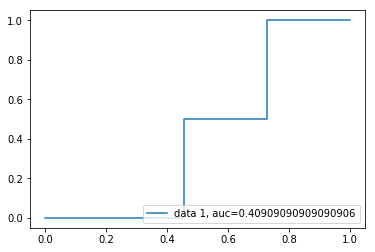

In [17]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Fitting and making predictions with DecisionTreeClassifier model.

---

In [18]:
# criterion: splitting decision function, can be 'gini' or 'entropy'
# max_depth: the maximum number of hierarchical decision nodes(how "deep" the tree is 
# built)

classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = classifier.feature_importances_

In [19]:
feature_importances

array([0.30982906, 0.30952381, 0.38064713, 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [20]:
# Model Accuracy, how often is the classifier correct?
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.92%


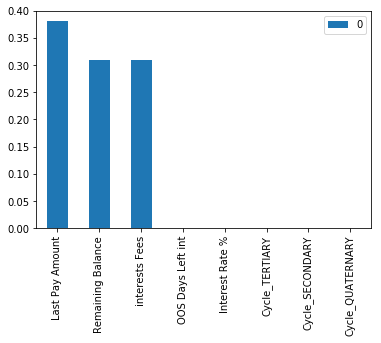

In [21]:
importances = list(zip(classifier.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

##### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.45. AUC score 1 represents perfect classifier, and 0.45 represents a worthless classifier.

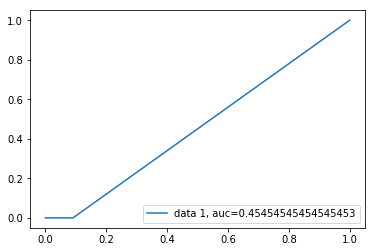

In [22]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Fitting and making predictions with RandomForestClassifier model.

-----

In [23]:
#Create a Gaussian Classifier
classifier=RandomForestClassifier(n_estimators=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
classifier.fit(X_train,y_train)

# prediction on test set
y_pred=classifier.predict(X_test)

# Model Accuracy, how often is the classifier correct?
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.62%


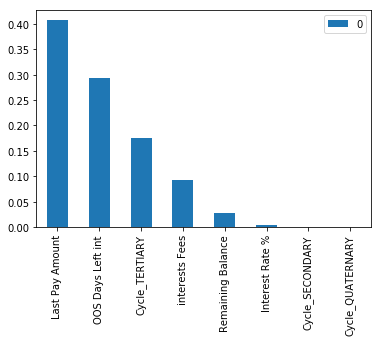

In [24]:
importances = list(zip(classifier.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

##### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.81. AUC score 1 represents perfect classifier, and 0.81 represents a good classifier.

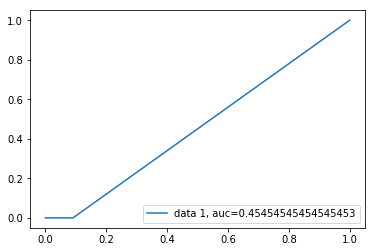

In [25]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Fitting and making predictions with XGBoost model.

---

In [26]:
xgb_model = xgb.XGBClassifier(objective ='reg:logistic', 
                              colsample_bytree = 0.3, 
                              learning_rate = 0.1,
                              max_depth = 5, 
                              alpha = 10, 
                              n_estimators = 10)
xgb_model.fit(X_train, y_train)

print(xgb_model)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [27]:
# make predictions for test data
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.62%


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


##### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.27. AUC score 1 represents perfect classifier, and 0.27 represents a worthless classifier.

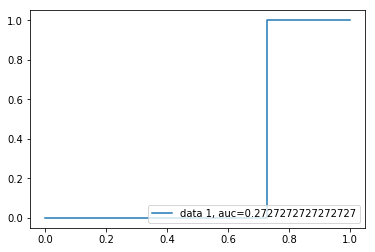

In [28]:
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Fitting and making predictions with KNeighborsClassifier model.

---

#### Instantiate KNN

For the `KNeighborsClassifier`, there a few important parameters to keep in mind:

1. `n_neighbors`: this is the "K" in KNN. The best K will change from problem to problem, but the default is 5.
2. `weights`: The neighbors can all have an equal vote (`uniform`), or the closer points can have a higher weighted vote (`distance`).
3. `p`: The distance metric. The default is Euclidean distance (2). Changing it to 1 is setting the distance to Manhattan.

In the cell below, instantiate a `knn` model using the default parameters.

In [29]:
# Because these are dummy vaiables scaling is not required
features = ['Cycle_QUATERNARY', 'Cycle_SECONDARY', 'Cycle_TERTIARY']
X_knn = df[features]
y_knn = df['Paid']

# Split dataset into training set and test set 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3) 

In [30]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

# Model Accuracy, how often is the classifier correct?
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.23%


#### Cross validation

In the cell below, use `cross_val_score` to see what accuracy we can expect from our KNN model.

In [31]:
print(cross_val_score(knn, X_train, y_train).mean())

0.9696969696969697


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [32]:
# 